# Libraries

In [1]:
!pip install textblob
!pip install nltk
!pip install imblearn

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import time
import os 
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kelvinyeung/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

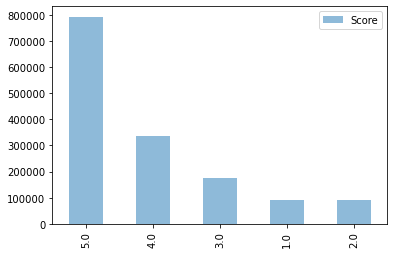


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./train.csv")
testingSet = pd.read_csv("./test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
# Define feature extraction function
def add_features_to(df):
    start_time = time.time()
    print("Starting feature extraction...")

    # Feature 1: Helpfulness ratio
    print("Calculating Helpfulness ratio...")
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    print("Helpfulness ratio calculated.")

    # Initialize VADER for sentiment analysis
    print("Initializing VADER...")
    sia = SentimentIntensityAnalyzer()

    def sentiment_analysis(text, summary=None):
        # Ensure text and summary are strings; if not, treat as empty strings
        text = str(text) if isinstance(text, str) else ""
        summary = str(summary) if isinstance(summary, str) else ""

        # TextBlob Polarity score 
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        vader_scores = sia.polarity_scores(text)
        compound_score = vader_scores['compound']

        contain_pos_sent = False
        contain_neg_sent = False
        for sentence in blob.sentences:
            sentence_polarity = sentence.sentiment.polarity
            if sentence_polarity > 0:
                contain_pos_sent = True
            elif sentence_polarity < 0:
                contain_neg_sent = True
        mixed_review = contain_pos_sent and contain_neg_sent

        # Polarity score of summary 
        summary_polarity = TextBlob(summary).sentiment.polarity if summary else None
        return polarity, compound_score, mixed_review, summary_polarity

    # Feature 2-5: Parallelized Sentiment Analysis with Progress Bar
    print("Starting parallel sentiment analysis on reviews...")
    sentiment_data = Parallel(n_jobs=-1)(
        delayed(sentiment_analysis)(row['Text'], row['Summary']) 
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Sentiment Analysis Progress")
    )
    df[['Polarity', 'CompoundScore', 'MixedSentiment', 'SummaryPolarity']] = pd.DataFrame(sentiment_data, index=df.index)
    print("Sentiment analysis features completed.")

    # Feature 6-7: User Sentiment Tendency and User Is Critical
    print("Calculating UserSentimentTendency and UserIsCritical...")
    user_avg_sentiment = df.groupby('UserId')['Polarity'].transform('mean')
    df['UserSentimentTendency'] = user_avg_sentiment
    df['UserIsCritical'] = user_avg_sentiment < user_avg_sentiment.median()
    print("UserSentimentTendency and UserIsCritical calculated.")

    # Feature 8: User Helpfulness Avg
    print("Calculating UserHelpfulnessAvg...")
    user_helpfulness_avg = df.groupby('UserId')['Helpfulness'].transform('mean')
    df['UserHelpfulnessAvg'] = user_helpfulness_avg
    print("UserHelpfulnessAvg calculated.")

    # Feature 9: Product Popularity
    print("Calculating ProductPopularity...")
    product_review_count = df.groupby('ProductId')['Id'].transform('count')
    df['ProductPopularity'] = product_review_count
    print("ProductPopularity calculated.")

    # Feature 10: Review Length (number of words in the review text)
    print("Calculating ReviewLength...")
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    print("ReviewLength calculated.")
    
    # TF-IDF for Text and Summary
    print("Vectorizing Text and Summary with TF-IDF...")
    tfidf_text = TfidfVectorizer(max_features=500)
    tfidf_summary = TfidfVectorizer(max_features=250)

    # Fit-transform for Text and Summary with NaN handling
    text_tfidf = tfidf_text.fit_transform(df['Text'].fillna(''))
    summary_tfidf = tfidf_summary.fit_transform(df['Summary'].fillna(''))

    # Combine text and summary TF-IDF matrices horizontally
    print("Combining Text and Summary TF-IDF matrices...")
    combined_tfidf = hstack([text_tfidf, summary_tfidf])

    # Apply TruncatedSVD to reduce dimensionality
    print("Applying TruncatedSVD to reduce dimensionality of TF-IDF features...")
    svd = TruncatedSVD(n_components=50, random_state=42)
    tfidf_svd = svd.fit_transform(combined_tfidf)
    print(f"Explained variance ratio sum with 50 components: {svd.explained_variance_ratio_.sum():.4f}")

    # Create a DataFrame with the SVD components
    print("Creating DataFrame with SVD components...")
    svd_columns = [f'svd_tfidf_{i+1}' for i in range(tfidf_svd.shape[1])]
    tfidf_svd_df = pd.DataFrame(tfidf_svd, columns=svd_columns, index=df.index)

    # Concatenate SVD components with df
    print("Concatenating SVD components with the original DataFrame...")
    df = pd.concat([df.reset_index(drop=True), tfidf_svd_df.reset_index(drop=True)], axis=1)

    # Optionally drop the original 'Text' and 'Summary' columns
    print("Dropping original 'Text' and 'Summary' columns...")
    df = df.drop(columns=['Text', 'Summary'])

    # Track total feature count
    total_features = len(df.columns) - 2  # Excluding 'Id' and 'Score' if present
    print(f"Total features added: {total_features}")
    print(f"Feature extraction complete. Total time: {time.time() - start_time:.2f} seconds")
    
    return df

# Load the feature extracted files if they've already been generated
if os.path.exists('./X_train.csv') and os.path.exists('./X_submission.csv'):
    X_train = pd.read_csv("./X_train.csv")
    X_submission = pd.read_csv("./X_submission.csv")
    print(f"Loaded preprocessed X_train with {len(X_train)} rows.")
    print(f"Loaded preprocessed X_submission with {len(X_submission)} rows.")
else:
    # Step 1: Process the full training set for feature extraction
    train = add_features_to(trainingSet)
    print("Feature extraction on training data completed.")

    # Step 2: Create the training set by filtering rows with known `Score`
    X_train = train[train['Score'].notnull()]
    print(f"Using the full training set with {len(X_train)} rows for training.")

    # Step 3: Merge on 'Id' to create the submission set with feature columns as well
    testingSet = pd.read_csv('test.csv')  # Load `test.csv`
    X_submission = pd.merge(train, testingSet[['Id']], left_on='Id', right_on='Id')
    print(f"X_submission prepared with {len(X_submission)} rows after merging.")

    # Step 4: Drop `Score` from `X_submission`, as it’s unknown
    if 'Score' in X_submission.columns:
        X_submission = X_submission.drop(columns=['Score'])

    # Save the processed datasets for future reuse
    X_train.to_csv("./X_train.csv", index=False)
    X_submission.to_csv("./X_submission.csv", index=False)
    print("Saved processed X_train (full dataset) and X_submission files.")

# Verification step to ensure correct row counts for `X_submission`
expected_rows = 212192
actual_rows = len(X_submission)
assert actual_rows == expected_rows, f"Row count mismatch: X_submission has {actual_rows} rows; expected {expected_rows}."
print("X_submission is correctly set with the expected 212,192 rows.")




Loaded preprocessed X_train with 1485341 rows.
Loaded preprocessed X_submission with 212192 rows.
X_submission is correctly set with the expected 212,192 rows.


# Sample + Split into training and testing set

In [5]:
print("Columns in X_train after feature extraction:", X_train.columns)

Columns in X_train after feature extraction: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Score', 'Helpfulness', 'Polarity',
       'CompoundScore', 'MixedSentiment', 'SummaryPolarity',
       'UserSentimentTendency', 'UserIsCritical', 'UserHelpfulnessAvg',
       'ProductPopularity', 'ReviewLength', 'svd_tfidf_1', 'svd_tfidf_2',
       'svd_tfidf_3', 'svd_tfidf_4', 'svd_tfidf_5', 'svd_tfidf_6',
       'svd_tfidf_7', 'svd_tfidf_8', 'svd_tfidf_9', 'svd_tfidf_10',
       'svd_tfidf_11', 'svd_tfidf_12', 'svd_tfidf_13', 'svd_tfidf_14',
       'svd_tfidf_15', 'svd_tfidf_16', 'svd_tfidf_17', 'svd_tfidf_18',
       'svd_tfidf_19', 'svd_tfidf_20', 'svd_tfidf_21', 'svd_tfidf_22',
       'svd_tfidf_23', 'svd_tfidf_24', 'svd_tfidf_25', 'svd_tfidf_26',
       'svd_tfidf_27', 'svd_tfidf_28', 'svd_tfidf_29', 'svd_tfidf_30',
       'svd_tfidf_31', 'svd_tfidf_32', 'svd_tfidf_33', 'svd_tfidf_34',
       'svd_tfidf_35', 'svd_tfidf_36', 'svd_tfidf_

In [6]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)


In [7]:
from sklearn.impute import SimpleImputer

# Define the features list, including all numeric columns
features = ['Helpfulness', 'CompoundScore', 'SummaryPolarity',
            'UserSentimentTendency', 'UserHelpfulnessAvg', 'ProductPopularity', 'Polarity', 'ReviewLength']

# Ensure no NaN or infinite values are present
X_train[features] = X_train[features].fillna(0)
X_train[features] = X_train[features].replace([np.inf, -np.inf], 0)

# Convert sparse columns (like TF-IDF) to dense if they exist
X_train_dense = X_train[features].apply(lambda x: x.sparse.to_dense() if x.dtype == "Sparse" else x)

# Initialize SMOTE
smote = SMOTE(random_state=0)

# Apply SMOTE to balance the classes in the training set
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_dense, Y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(Y_train_balanced.value_counts())

Class distribution after SMOTE:
5.0    595120
2.0    595120
1.0    595120
4.0    595120
3.0    595120
Name: Score, dtype: int64


# Feature Selection

In [12]:
# Confirm shapes before feature selection
print("Shapes before feature selection:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_submission shape: {X_submission.shape}")

# Parameters for sampling
sample_size = 100000  # Adjusted sample size
additional_features = 15  # Number of additional SVD/TF-IDF features to keep

# Define your selected original features
original_features = ['Helpfulness', 'CompoundScore', 'SummaryPolarity',
                     'UserSentimentTendency', 'UserHelpfulnessAvg',
                     'ProductPopularity', 'Polarity', 'ReviewLength']

# Step 1: Downsample the training dataset
print(f"Original training data shape: {X_train.shape}")
X_train_sampled = X_train.sample(n=sample_size, random_state=42)
Y_train_sampled = Y_train.loc[X_train_sampled.index]  # Ensure labels match sampled rows
print(f"Downsampled training data shape: {X_train_sampled.shape}")

# Step 2: Identify TF-IDF/SVD columns
svd_features = [col for col in X_train.columns if 'svd_tfidf' in col]

# Step 3: Apply SelectKBest to choose the top 30 SVD features
print("Selecting top 15 SVD/TF-IDF features based on importance...")
selector = SelectKBest(score_func=f_classif, k=additional_features)
X_train_svd_selected = selector.fit_transform(X_train_sampled[svd_features], Y_train_sampled)
selected_svd_feature_indices = selector.get_support(indices=True)
selected_svd_features = [svd_features[i] for i in selected_svd_feature_indices]

# Combine original features with the top 30 SVD/TF-IDF features
selected_features = original_features + selected_svd_features
X_train_sampled = X_train_sampled[selected_features]
X_test_reduced = X_test[selected_features]

print(f"Features selected for model training: {selected_features}")
print(f"Reduced training data shape: {X_train_sampled.shape}")
print(f"Reduced test data shape: {X_test_reduced.shape}")

# Step 4: Scale the downsampled data if needed
scaler = StandardScaler()
X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

Shapes before feature selection:
X_train shape: (1114005, 66)
X_test shape: (371336, 66)
X_submission shape: (212192, 66)
Original training data shape: (1114005, 66)
Downsampled training data shape: (100000, 66)
Selecting top 15 SVD/TF-IDF features based on importance...
Features selected for model training: ['Helpfulness', 'CompoundScore', 'SummaryPolarity', 'UserSentimentTendency', 'UserHelpfulnessAvg', 'ProductPopularity', 'Polarity', 'ReviewLength', 'svd_tfidf_1', 'svd_tfidf_2', 'svd_tfidf_3', 'svd_tfidf_4', 'svd_tfidf_7', 'svd_tfidf_9', 'svd_tfidf_10', 'svd_tfidf_11', 'svd_tfidf_12', 'svd_tfidf_17', 'svd_tfidf_22', 'svd_tfidf_23', 'svd_tfidf_32', 'svd_tfidf_36', 'svd_tfidf_43']
Reduced training data shape: (100000, 23)
Reduced test data shape: (371336, 23)


# Model Creation

In [13]:

# Step 1: Check for NaN and infinity values in scaled data and replace them
print("Checking for NaN and infinity values in scaled data...")
X_train_sampled_scaled = np.nan_to_num(X_train_sampled_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_reduced_scaled = np.nan_to_num(X_test_reduced_scaled, nan=0.0, posinf=0.0, neginf=0.0)
print("Data cleaned.")

# Range of n_neighbors to test
n_neighbors_values = [20, 50, 70, 100]
accuracies = {}

print("\n=== TESTING DIFFERENT VALUES OF n_neighbors ===")

# Loop through each value of n_neighbors
for n in n_neighbors_values:
    print(f"\nTesting n_neighbors={n}...")
    start_time = time.time()  # Track start time
    
    # Initialize the KNeighborsClassifier with current n_neighbors and 'distance' weight
    model = KNeighborsClassifier(n_neighbors=n, weights='distance')
    
    # Train the model on the reduced and scaled training data
    model.fit(X_train_sampled_scaled, Y_train_sampled)
    
    # Predict on the reduced and scaled test set
    Y_test_predictions = model.predict(X_test_reduced_scaled)
    
    # Calculate and store the accuracy
    accuracy = accuracy_score(Y_test, Y_test_predictions)
    accuracies[n] = accuracy
    elapsed_time = time.time() - start_time  # Track end time
    print(f"Accuracy with n_neighbors={n}: {accuracy:.4f} (Time taken: {elapsed_time:.2f} seconds)")

# Display accuracies for all tested n_neighbors
print("\n=== Accuracies for different n_neighbors values ===")
for n, acc in accuracies.items():
    print(f"n_neighbors={n}: {acc:.4f}")

# Identify the best n_neighbors based on highest accuracy
best_n = max(accuracies, key=accuracies.get)
print(f"\nBest n_neighbors based on accuracy: {best_n} with accuracy {accuracies[best_n]:.4f}")

Checking for NaN and infinity values in scaled data...
Data cleaned.

=== TESTING DIFFERENT VALUES OF n_neighbors ===

Testing n_neighbors=20...
Accuracy with n_neighbors=20: 0.5684 (Time taken: 823.48 seconds)

Testing n_neighbors=50...


KeyboardInterrupt: 

In [15]:
# Initialize and train the KNN model with the chosen n_neighbors (e.g., 100)

print("Training the KNN model with n_neighbors=100 on the sampled and scaled training data...")
start_time = time.time() 
model = KNeighborsClassifier(n_neighbors=100, weights='distance')
model.fit(X_train_sampled_scaled, Y_train_sampled)

train_time = time.time() - start_time  # Calculate training time
print(f"Model training completed in {train_time:.2f} seconds.")

print("Predicting on the reduced and scaled test set...")
start_time = time.time() 
# Predict the scores on the reduced and scaled test data
print("Predicting on the reduced and scaled test set...")
Y_test_predictions = model.predict(X_test_reduced_scaled)

predict_time = time.time() - start_time  # Calculate prediction time
print(f"Predictions on the test set completed in {predict_time:.2f} seconds.")

print("Predictions on the test set:")
print(Y_test_predictions[:10]) 

# Display predictions for verification (optional)
print("Predictions on the test set completed.")

Training the KNN model with n_neighbors=100 on the sampled and scaled training data...
Model training completed in 0.02 seconds.
Predicting on the reduced and scaled test set...
Predicting on the reduced and scaled test set...
Predictions on the test set completed in 836.61 seconds.
Predictions on the test set:
[5. 5. 3. 5. 1. 5. 5. 4. 5. 5.]
Predictions on the test set completed.


# Model Evaluation

Accuracy on testing set =  0.5777409138893078


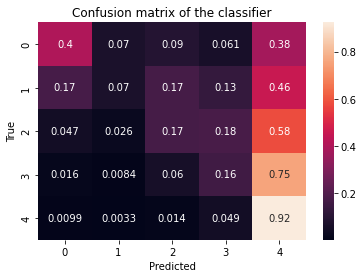

In [16]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [19]:
# Re-select features in X_submission to match the trained model's features
selected_features = original_features + selected_svd_features  # Use features identified during training
X_submission_reduced = X_submission[selected_features]

# Apply the same scaling as was done for training
X_submission_reduced_scaled = scaler.transform(X_submission_reduced)

# Clean any NaN or infinite values in X_submission_reduced_scaled
X_submission_reduced_scaled = np.nan_to_num(X_submission_reduced_scaled, nan=0.0, posinf=0.0, neginf=0.0)

In [21]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_reduced_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./submission.csv", index=False)

In [22]:
print(f"Number of rows in submission: {len(submission)}")

Number of rows in submission: 212192
